In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.seq_multichannel_biogas import hparams
hparams = hparams()

### Define Data Generator

In [3]:
from data_loader.biogas import *
get_fields = 'AT305 FT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

### Define Model

In [4]:
def gru(units, name):
    # Use CuDNNGRU is GPU is available (provides a 3x speedup than GRU)
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_activation='relu',
                                        recurrent_initializer='glorot_uniform',
                                        name=name)
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='relu', 
                                   recurrent_initializer='glorot_uniform',
                                   name=name)

In [5]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, name=None):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, name=name + '_W1')
        self.W2 = tf.keras.layers.Dense(units, name=name + '_W2')
        self.V = tf.keras.layers.Dense(1, name=name + '_V')

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, 1)

        return context_vector, attention_weights

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, output_dim, layers, units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.layer_s = layers
        self.units = units
        self.cells = [gru(self.units, 'encoder_gru_%i' % i) for i in range(layers)]
        
    def call(self, x, hidden):
        outputs, states = [], []
        output = x
        
        for cell in self.cells:
            output, state = cell(output, initial_state = hidden)
            outputs.append(output)
            states.append(state)

        return outputs, states
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [7]:
class Decoder(tf.keras.Model):
    def __init__(self, output_dim, num_layers, neurons_unit, batch_size):
        super(Decoder, self).__init__()
        self.output_dim   = output_dim
        self.num_layers   = num_layers
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.cells = [gru(neurons_unit, 'decoder_gru_%i' % i) for i in range(num_layers)]
        self.attentions = [BahdanauAttention(neurons_unit, 'decoder_attn_%i' % i) for i in range(num_layers)]
        self.fc_out = tf.keras.layers.Dense(output_dim, activation='relu', name='decoder_affine_out')
                
    def call(self, x, dec_states, enc_outputs, mask):
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        dec_output = x
        states = []
        for layer, cell in enumerate(self.cells):
            context_vector, _ = self.attentions[layer](enc_outputs[layer], dec_states[layer])
        
            # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
            dec_output = tf.concat([context_vector, dec_output], axis=-1)

            # passing the concatenated vector to the GRU
            dec_output, dec_state = self.cells[layer](dec_output, initial_state=dec_states[layer])
            dec_states.append(dec_state)
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc_out(dec_output) * mask
        
        return x, dec_states
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [8]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, output_dim, num_layers, neurons_unit, batch_size):
        super(EncoderDecoder, self).__init__()
        self.output_dim   = output_dim
        self.num_layers   = num_layers
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size

        self.encoder = Encoder(output_dim, num_layers, neurons_unit, batch_size)
        self.decoder = Decoder(output_dim, num_layers, neurons_unit, batch_size)
    
    def call(self, inp, mask):
        hidden = self.encoder.initialize_hidden_state()
        enc_output, enc_hidden = self.encoder(inp, hidden)

        dec_hidden = enc_hidden

        dec_input = inp[:,0,:]
        for 
            dec_input = tf.concat(dec_input, inp[:,-1,-self.output_dim:]), axis=1)


        
        dec_input = tf.expand_dims(dec_input, 1)

        for t in range(0, inp.shape[1]):
            # passing enc_output to the decoder
            prediction, dec_hidden = self.decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])

            # Concatenate with prediction from previous time step
            dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), prediction), axis=2)
            
            if t == 0:
                predictions = prediction
            else:
                predictions = tf.concat([predictions, prediction], axis=1)
        
        return predictions

### Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Run a training session and print training statistics and model structure

Epoch 1 Loss 0.1204 Accuracy 0.1194
Time taken for 1 epoch 51.9744 sec

Epoch 2 Loss 0.0457 Accuracy 0.0447
Time taken for 1 epoch 52.5165 sec

Epoch 3 Loss 0.0409 Accuracy 0.0401
Time taken for 1 epoch 51.4533 sec

Epoch 4 Loss 0.0392 Accuracy 0.0384
Time taken for 1 epoch 52.6959 sec

Epoch 5 Loss 0.0375 Accuracy 0.0367
Time taken for 1 epoch 52.3231 sec

Epoch 6 Loss 0.0365 Accuracy 0.0357
Time taken for 1 epoch 52.1155 sec

Epoch 7 Loss 0.0355 Accuracy 0.0347
Time taken for 1 epoch 52.1022 sec

Epoch 8 Loss 0.0345 Accuracy 0.0338
Time taken for 1 epoch 51.6631 sec

Epoch 9 Loss 0.0341 Accuracy 0.0333
Time taken for 1 epoch 51.5228 sec

Epoch 10 Loss 0.0334 Accuracy 0.0327
Time taken for 1 epoch 51.4530 sec

Loss 0.0334 Accuracy 0.0327 Time 519.8222


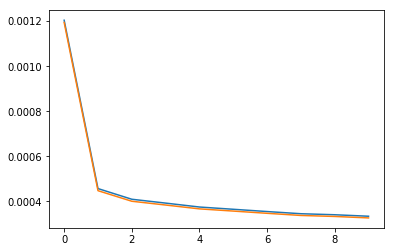

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  4128      
_________________________________________________________________
decoder_1 (Decoder)          multiple                  9603      
Total params: 13,731
Trainable params: 13,731
Non-trainable params: 0
_________________________________________________________________


In [32]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = EncoderDecoder(hparams.output_channels, hparams.num_layers, hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams, epochs=10, verbose=True)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
plt.plot(np.array(stats)[:,:2])
plt.show()

model.summary()

## Test Model Accuracy

In [14]:
model_accuracy = []

Total Accuracy: 0.1753


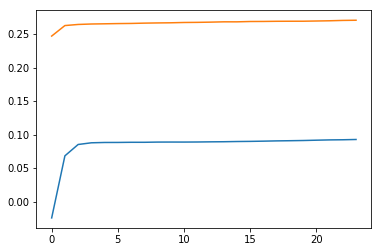

In [15]:
START_POINT = 0
total_accuracy = []

for i, (inp, target, mask, x_max) in enumerate(dataset_val):
    forecast = model(inp, mask)

    accuracy = (forecast - target) * x_max
    #accuracy = accuracy ** 2 / x_var
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

In [ ]:
plt.figure()
for t, data in model_accuracy:
    plt.plot(data, label = 'Training Set: %i hrs' % t)
plt.legend()
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Relative Squared Error')
plt.title('Encoder-Decoder Network')
plt.plot()

### Test Hyperparameters
#CHECKED

In [37]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for _ in range(25):
#   lr = np.random.uniform(-8, -1, 1):
#   nodes = np.floor(2 ** np.random.randint((3,9))):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = EncoderDecoder(hparams.output_channels, hparams.num_layers, hparams.neurons_unit, hparams.batch_size)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 2, verbose=False)
    print('Learning Rate {:.4f} Nodes {} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(\
                lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -4.0000 Nodes 32 Loss 0.0464 Accuracy 0.0454 Time 103.8
Learning Rate -3.5000 Nodes 32 Loss 0.0457 Accuracy 0.0447 Time 103.0
Learning Rate -3.0000 Nodes 32 Loss 0.0433 Accuracy 0.0425 Time 103.1
Learning Rate -2.5000 Nodes 32 Loss 0.0504 Accuracy 0.0497 Time 103.1
Learning Rate -2.0000 Nodes 32 Loss nan Accuracy nan Time 103.0


KeyboardInterrupt: 

### Make Predictions

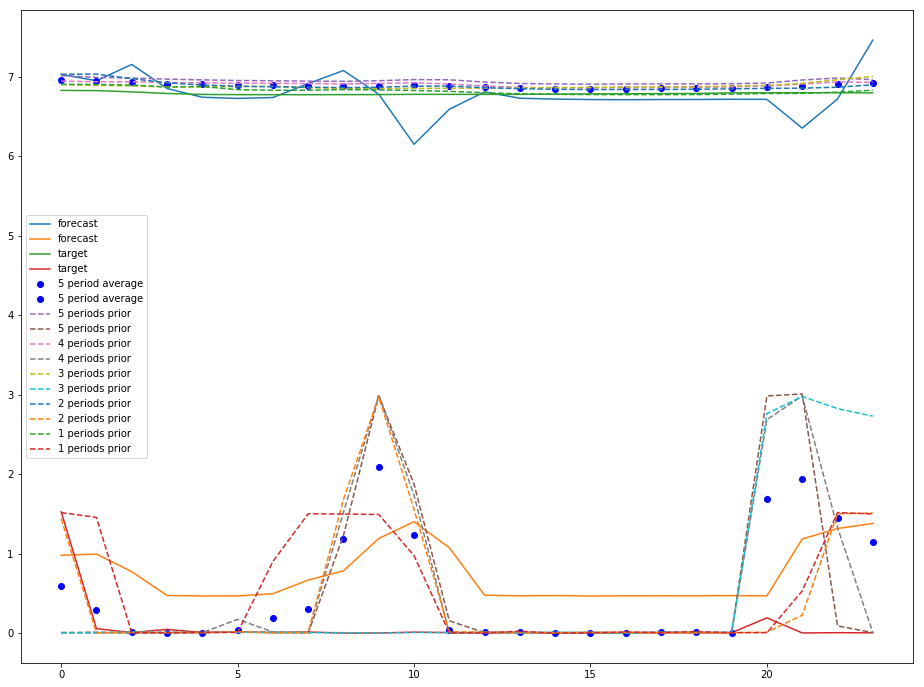

In [33]:
# Select target sequence to show
TARGET_INDEX = 12

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

In [ ]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=1), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=0)[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(forecast[:,i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

In [ ]:
l_ = np.sum((forecast.T - np.squeeze(target)[:,:-1]) ** 2, axis=1)
l_.argsort()

In [ ]:
loss = np.mean((forecast.T*8.15 - target[:,1:,0]*8.15) ** 2 / dataset.var(), axis=0)
plt.plot(loss)
plt.show()

Adapted from examples contained in the official Tensorflow github repo;
<href>https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb</href>